# <center>Group5 - Final Project </center>
# <center>Training</center>
## Section 3.1: Preprocessing the train data 

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import joblib

import warnings
warnings.filterwarnings('ignore')

## Load the data

In [113]:
df = pd.read_csv("train_data.csv")
df.columns = df.columns.str.strip()
print("Shape:", df.shape)
df.head()

Shape: (5807, 97)


,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,...,0.780554,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464
1,1,0,0.530005,0.572885,0.574763,0.605695,0.605558,0.999058,0.797512,0.809399,...,0.819963,0.005968,0.624171,0.605690,0.841869,0.279040,0.026801,0.565205,1,0.032442
2,2,0,0.571150,0.620148,0.624177,0.612275,0.612282,0.999163,0.797654,0.809533,...,0.839128,0.006022,0.625306,0.612271,0.843294,0.278927,0.026816,0.565276,1,0.033034
3,3,0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,...,0.806477,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406
4,4,0,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,...,0.799277,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858


In [117]:
X = df.drop(['Bankrupt?', 'Index'], axis=1)
y = df['Bankrupt?']
X.shape, y.shape


((5807, 95), (5807,))

### Finding correlation matrix

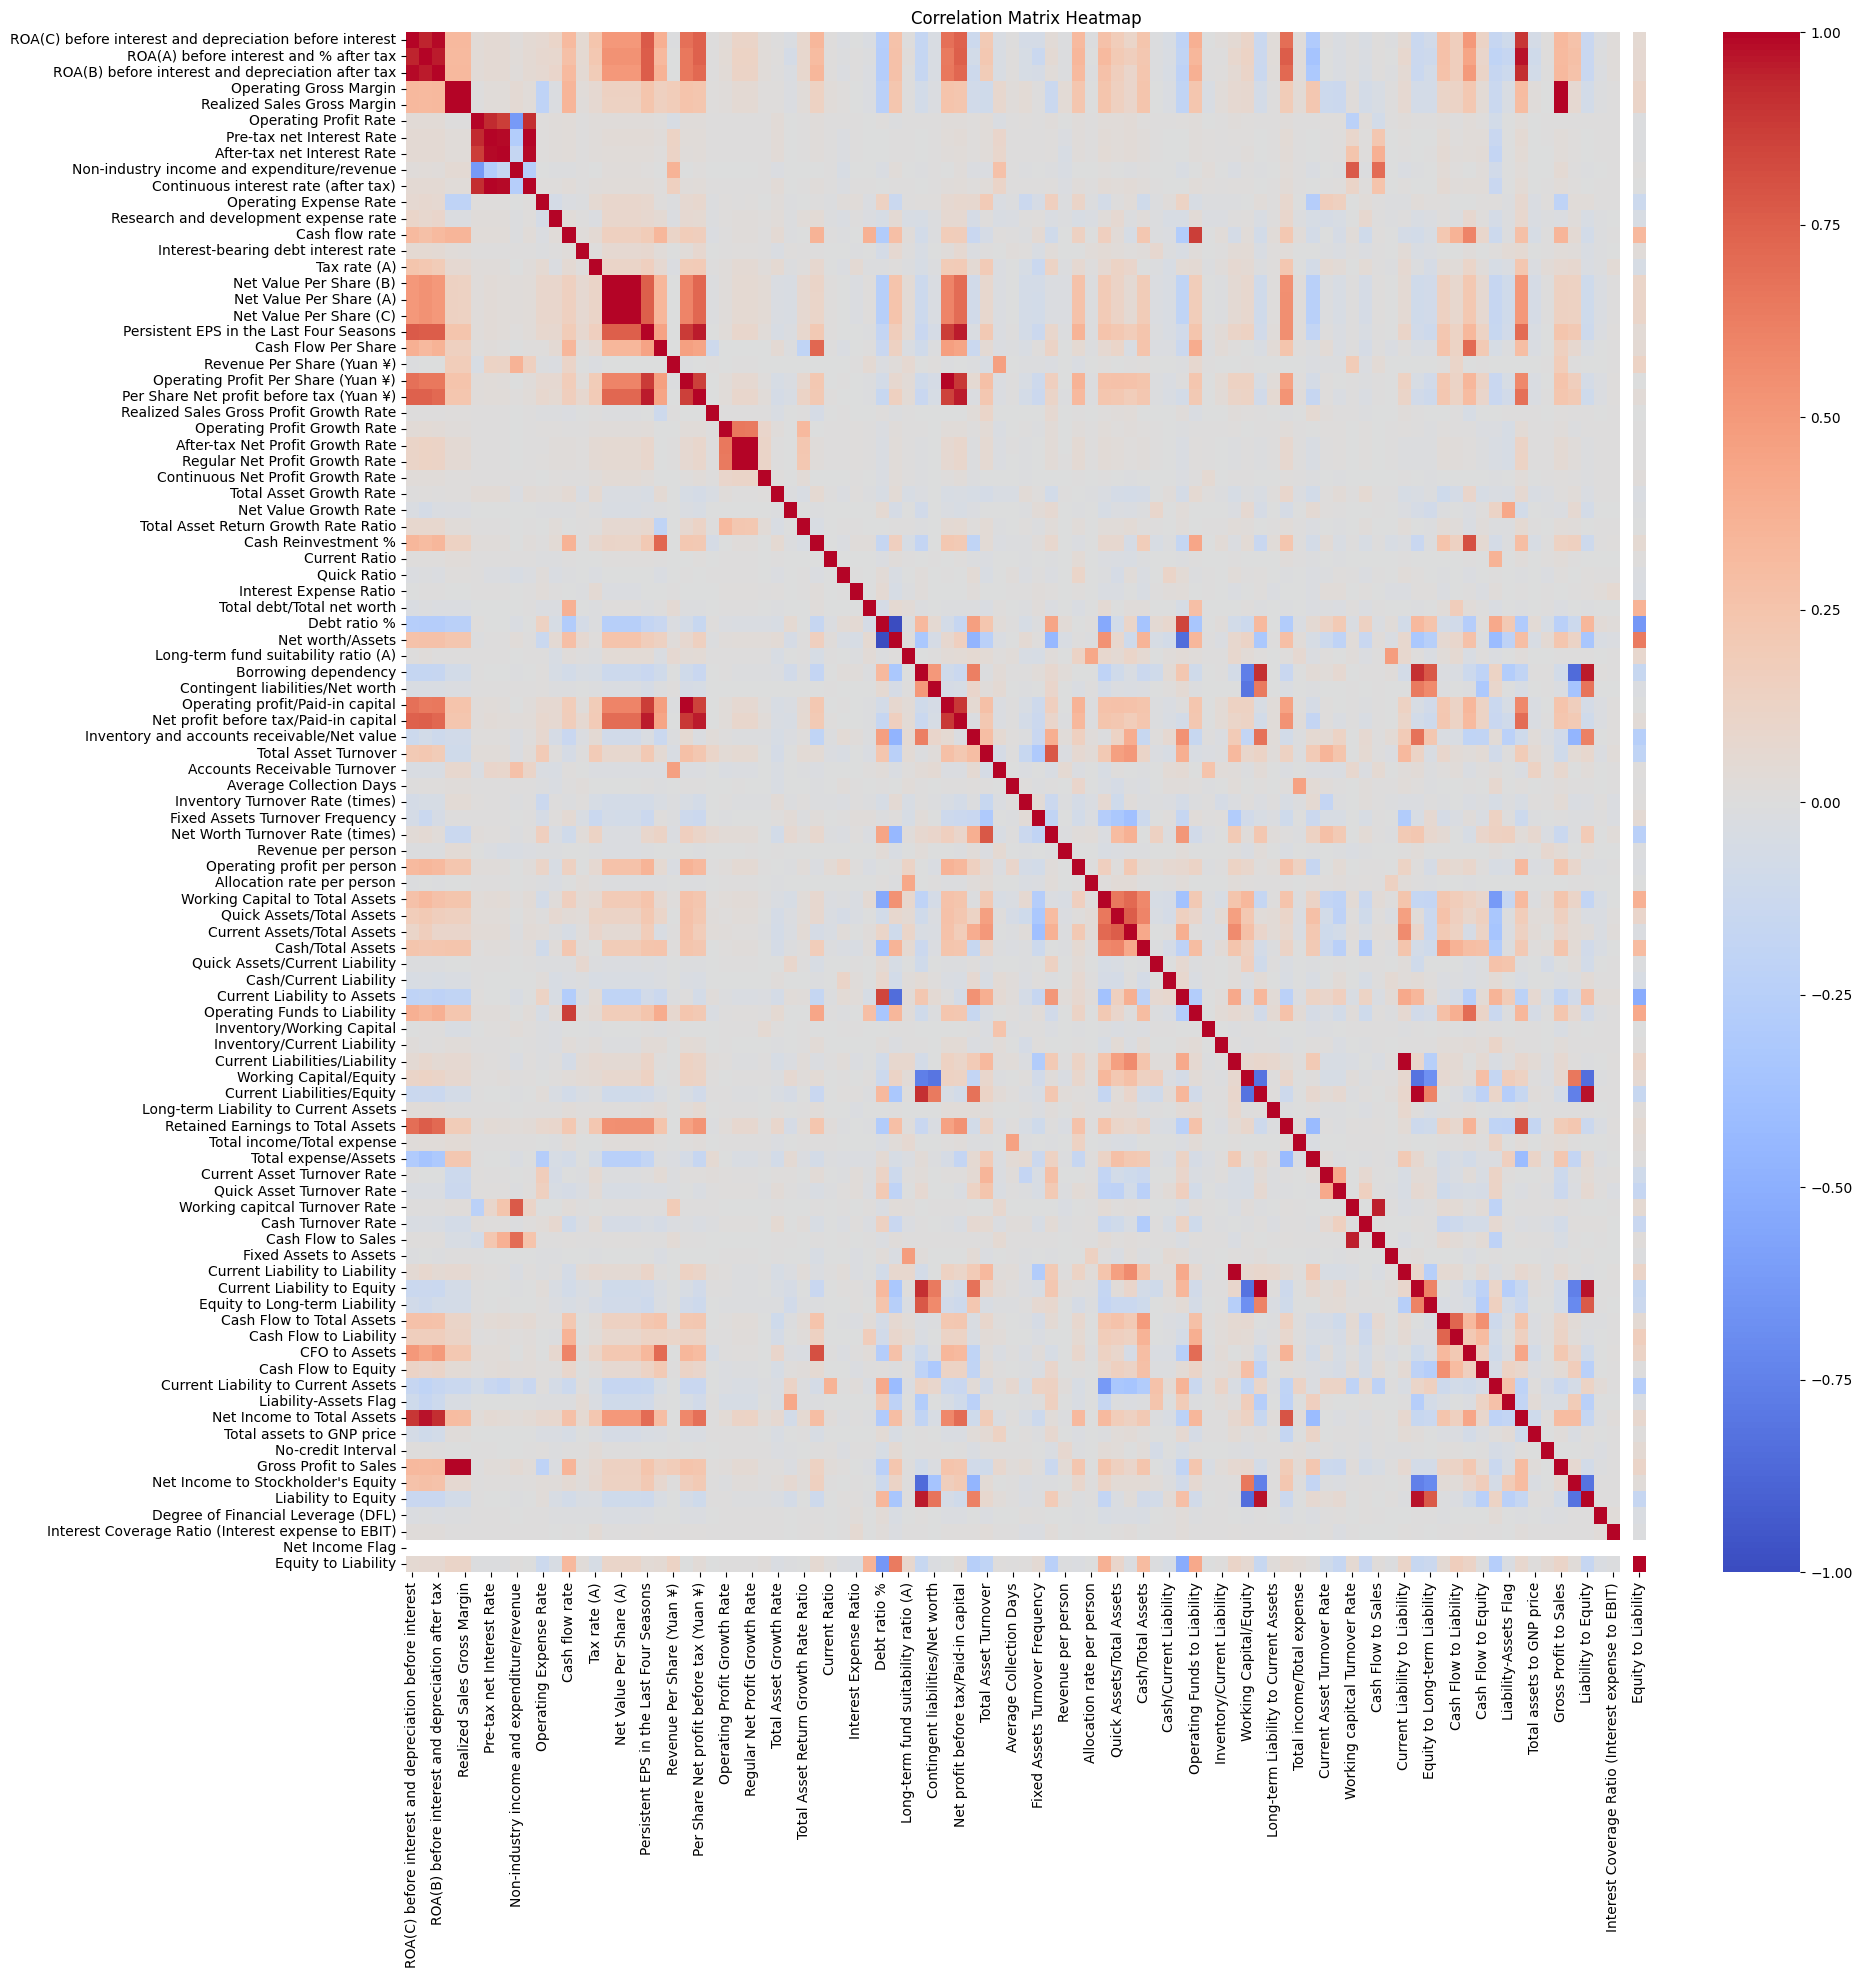

In [119]:
correlation = X.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Remove the columns that have correlation coefficient >= 0.95.

In [120]:
columns = np.full((correlation.shape[0],), True, dtype=bool) # create an array of True values with the same length as the number of columns
for i in range(correlation.shape[0]):
    for j in range(i+1, correlation.shape[0]):
        if correlation.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
                
selected_columns = X.columns[columns]
# print(selected_columns)
X = X[selected_columns] # Select the columns with correlation coefficient |ρ| < 0.95
X.shape

(5807, 79)

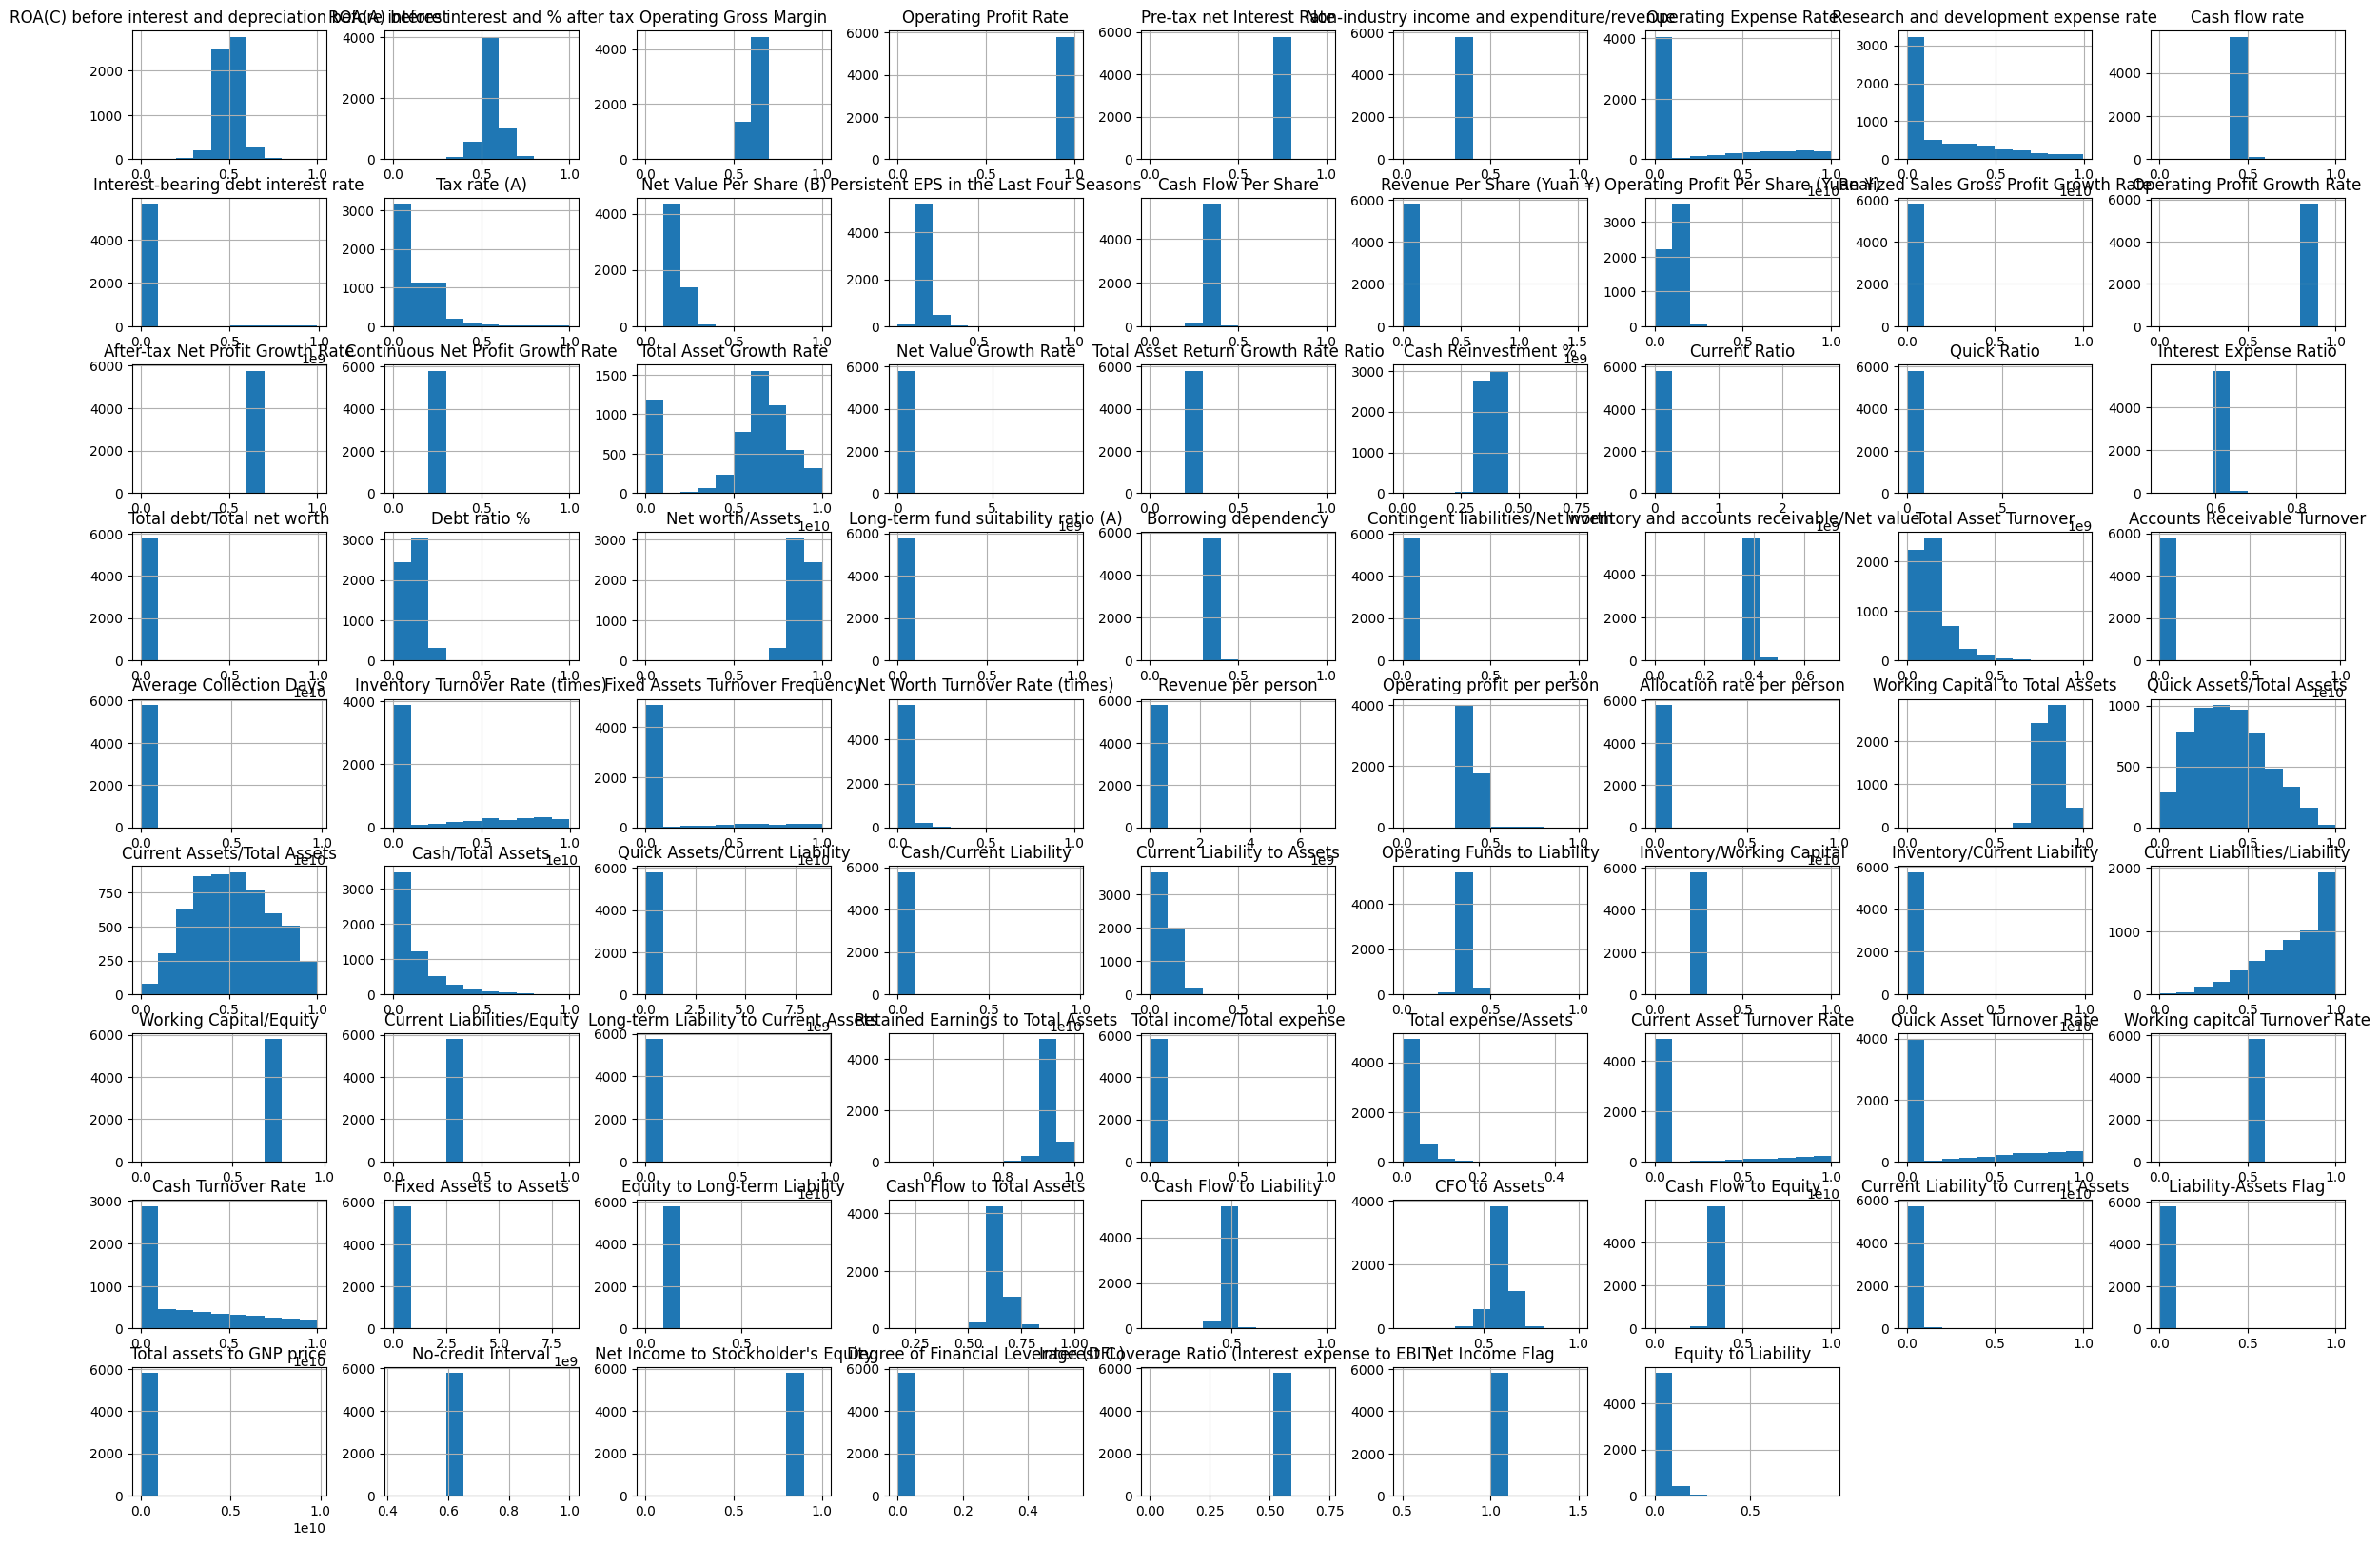

In [121]:
# plot hist of all features
X.hist(figsize=(30, 20));

### We can cap the outliers using the IQR method to avoid the effect of outliers on the model

In [122]:
def cap_outliers(data):
    data_capped = data.copy()
    for column in data_capped.columns:
        Q1 = data_capped[column].quantile(0.25)
        Q3 = data_capped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_capped[column] = np.where(data_capped[column] < lower_bound, lower_bound, data_capped[column])
        data_capped[column] = np.where(data_capped[column] > upper_bound, upper_bound, data_capped[column])
    return data_capped

In [123]:
X_outliers_capped = cap_outliers(X)
X_outliers_capped.shape

(5807, 79)

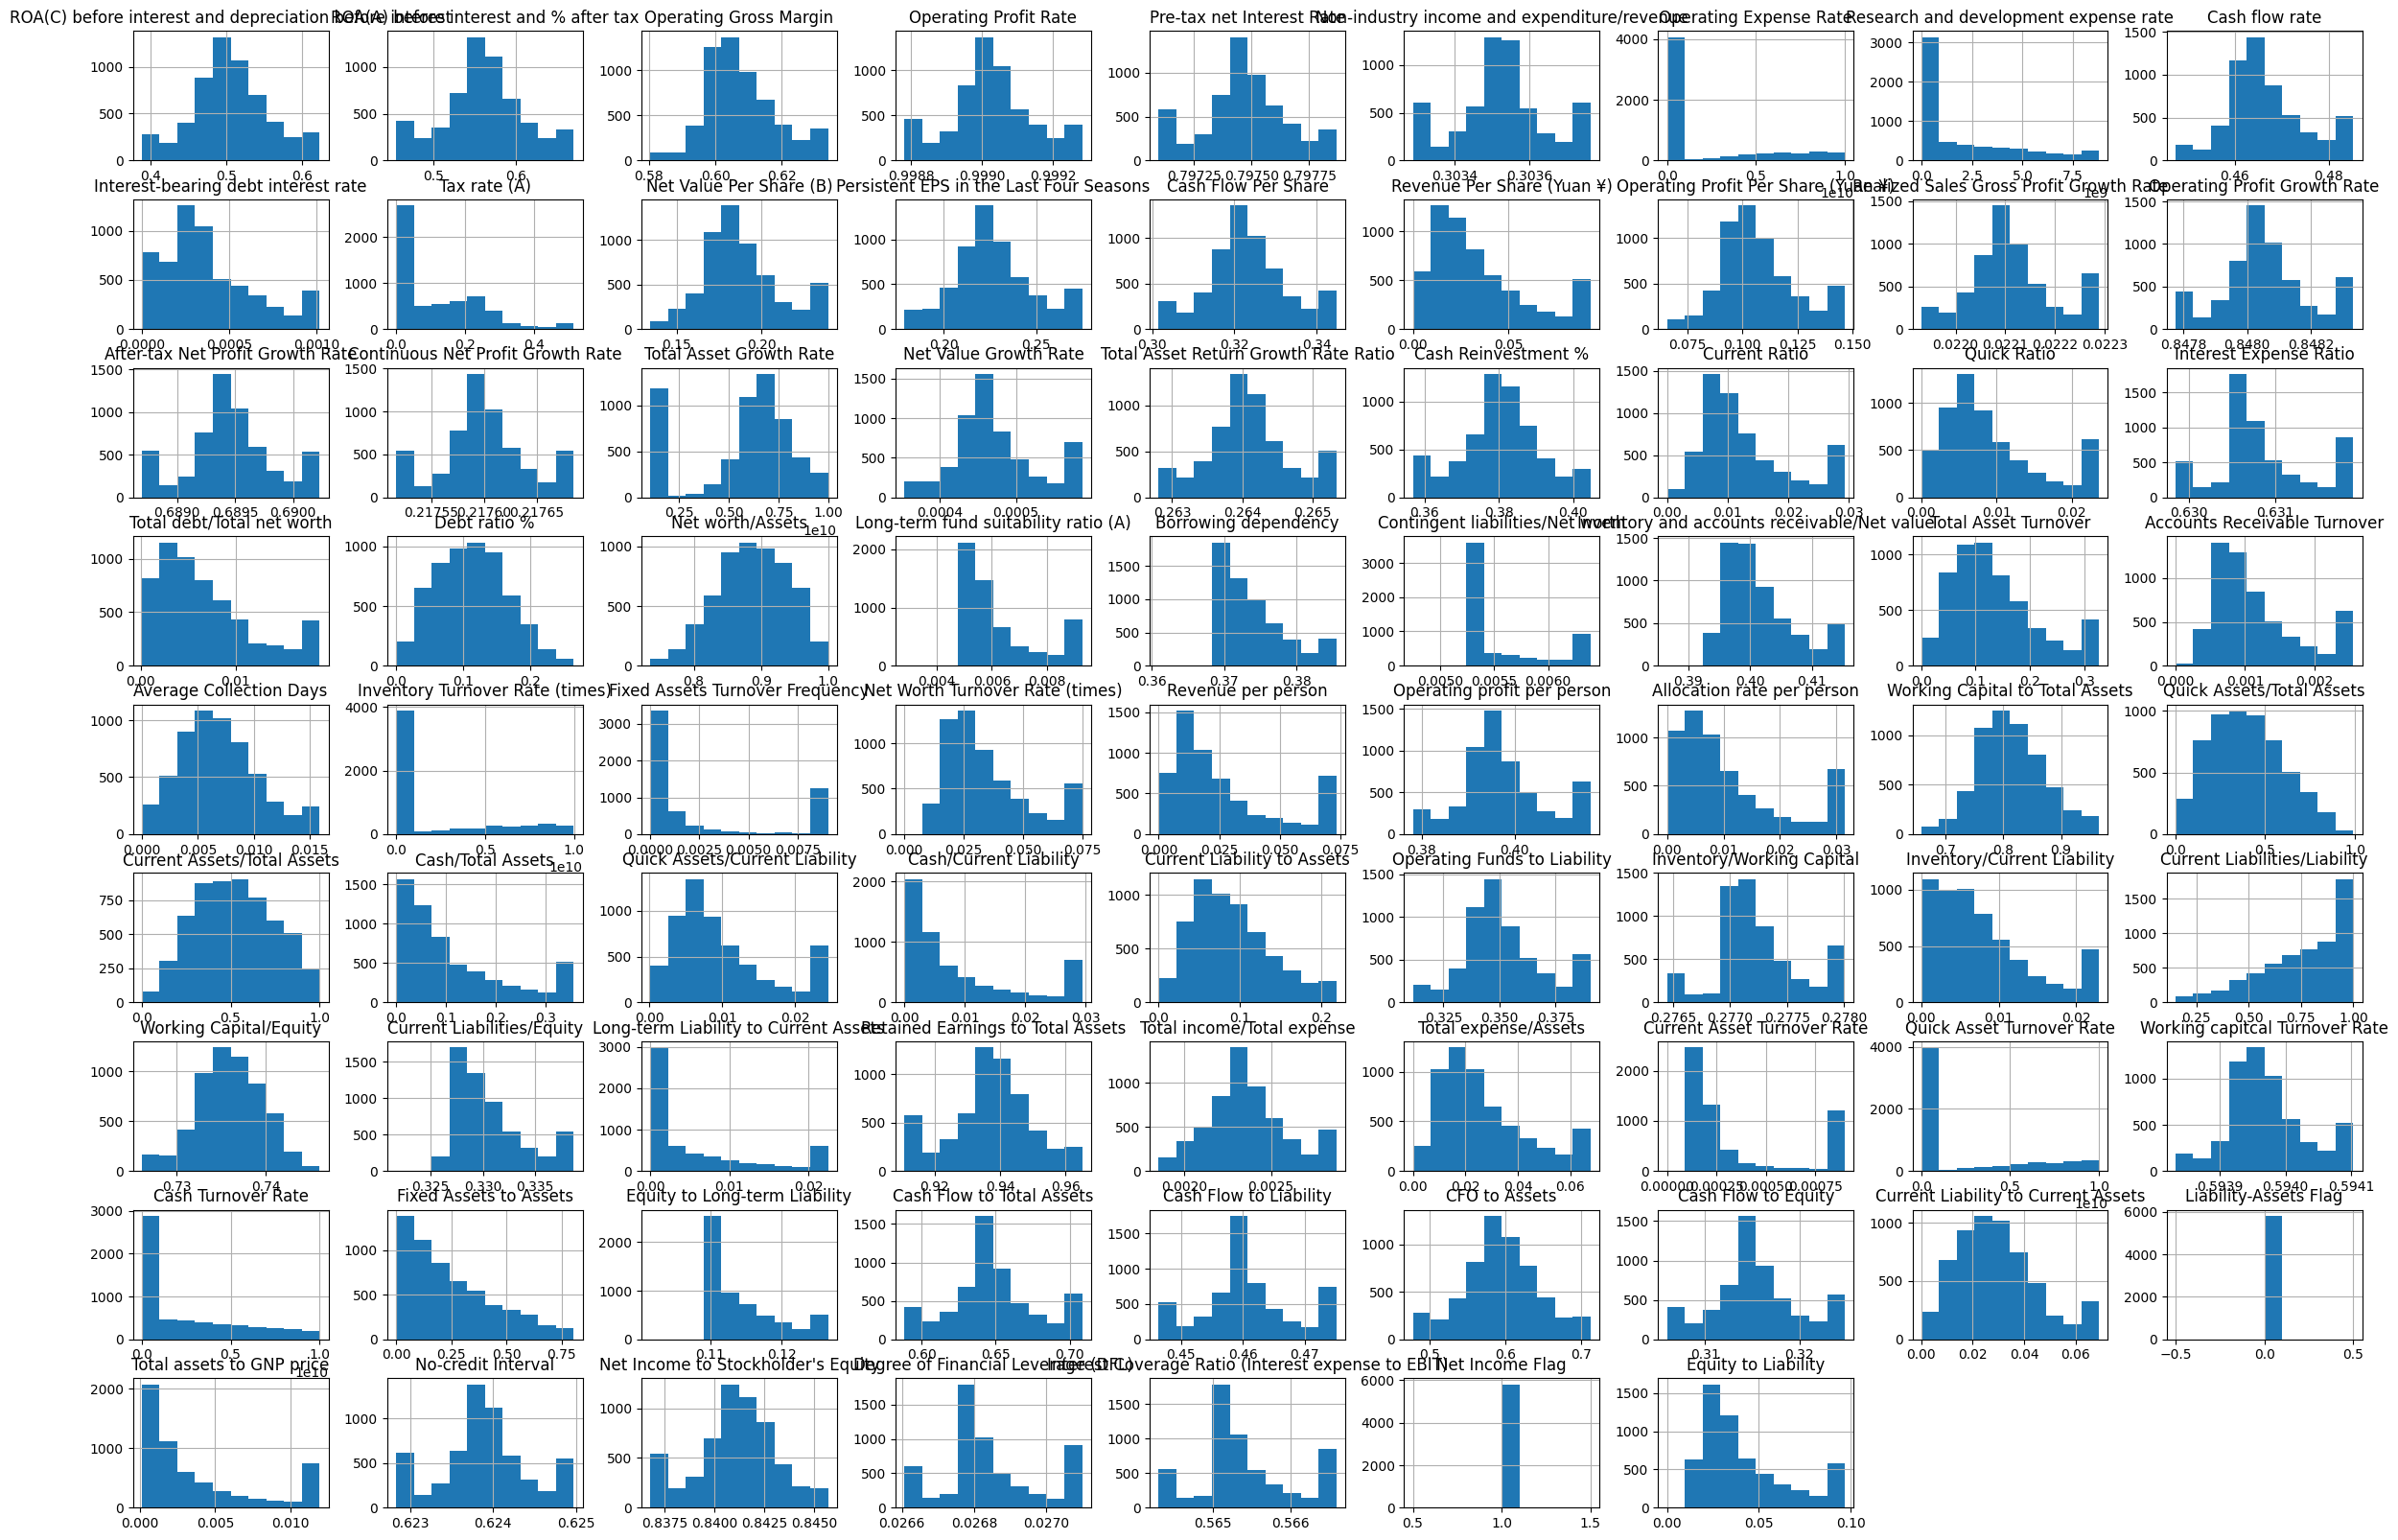

In [124]:
X_outliers_capped.hist(figsize=(30, 20));

### We will use PCA to reduce features to 90% of data

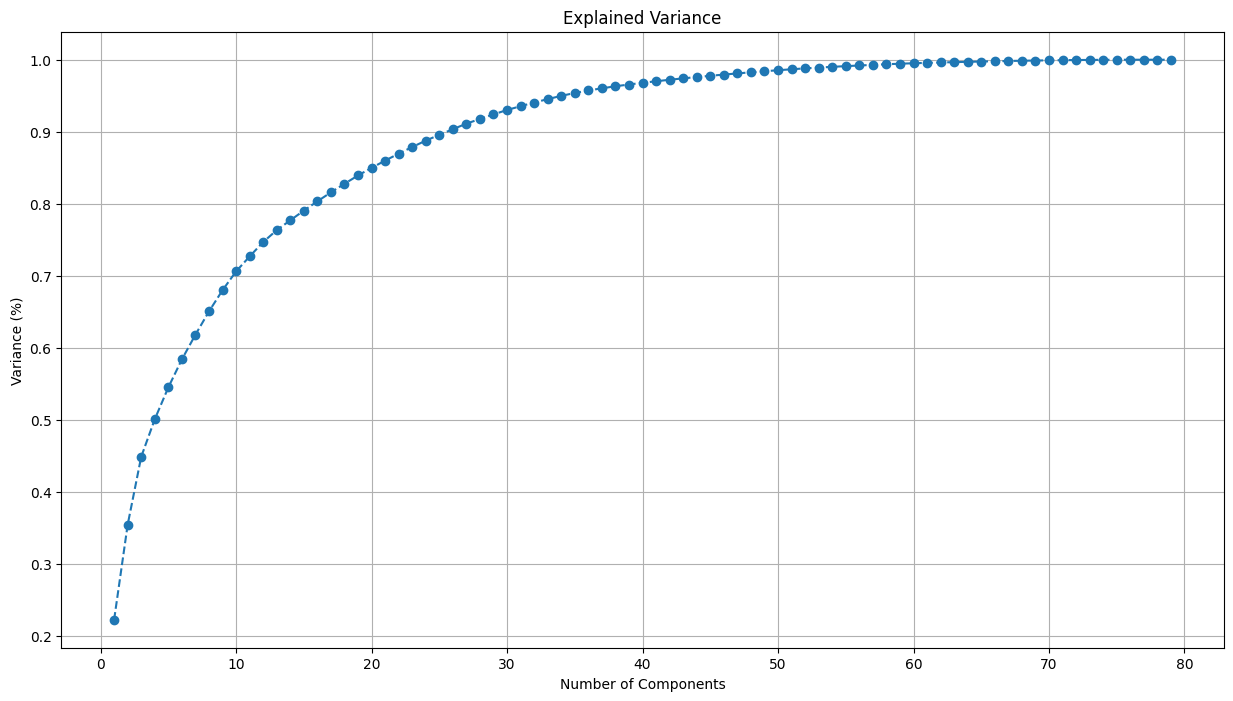

Number of components to save 90% of data: 26
Explained variance: 0.9035080311951497


In [125]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_outliers_capped)

pca = PCA(n_components=X_scaled.shape[1])
X_pca = pca.fit_transform(X_scaled)
explain = pca.explained_variance_ratio_
plt.figure(figsize=(15,8))
plt.plot(range(1,X_scaled.shape[1]+1),np.cumsum(explain), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.grid()
plt.show()
# Find best pca to save 0.95 data
n_components = np.argmax(np.cumsum(explain) >= 0.90)+1
print(f'Number of components to save 90% of data: {n_components}')
print(f'Explained variance: {np.cumsum(explain)[n_components-1]}')

In [126]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
0,-4.328723,-2.949938,-0.922311,1.347478,-1.875776,3.104547,-0.037355,-0.808933,1.108289,-0.216169,...,0.709021,0.597473,-0.567413,-0.585520,1.535418,0.053807,0.107681,0.011554,1.276770,0.275025
1,1.094151,1.472453,0.132183,-0.300871,-0.504754,-1.832859,-0.031414,-1.170645,0.008114,-0.556370,...,0.069746,-0.109543,-1.075769,-0.945268,-0.668545,-1.454529,-1.121609,0.843183,-0.421891,-0.419246
2,4.088633,1.259710,-1.776226,1.050030,1.501352,-0.340699,0.833061,-2.429603,-0.968284,0.329488,...,0.324172,0.542483,0.710081,-0.577257,-0.530180,-0.899643,-0.333037,-1.430197,0.090152,-0.655980
3,-3.933860,6.750754,2.322990,-4.176331,2.404033,3.765933,0.485070,0.206727,-1.427313,-1.984952,...,0.199349,0.970911,-1.761042,1.424276,1.402486,0.986018,1.197131,0.408706,0.192866,-0.402362
4,-0.695598,2.372324,3.048846,0.490309,-3.344630,0.242807,0.115051,0.733233,2.672528,2.512248,...,-0.486337,0.075081,-0.304360,-0.521027,-1.303879,0.050446,1.210307,0.004957,-0.065199,1.614544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,-5.203183,4.031399,-1.581381,1.820330,-0.722545,2.028990,0.957132,0.630203,2.033828,2.132394,...,-0.791870,0.094430,0.174076,2.099330,0.006118,-0.791407,-1.386877,-2.299045,0.043732,-1.686468
5803,4.902789,-0.720811,-1.637984,1.788276,1.356479,0.370058,-0.787408,0.526895,-0.621148,-1.903530,...,0.847135,-0.396504,0.458130,0.187679,0.516685,-0.450227,-0.364332,0.938161,1.827889,-0.292877
5804,-0.236553,3.246341,4.359812,1.112903,-2.900938,2.344548,0.729337,0.297779,1.444583,0.676542,...,0.586340,-0.695289,0.165836,-0.303646,-0.785945,-0.318931,-0.123591,0.970680,0.812879,-0.446003
5805,4.654429,-0.126940,3.109156,3.148626,3.840758,2.273918,0.652784,-0.017399,-0.667480,1.745919,...,-0.592604,-0.854298,-1.251939,0.627141,0.380296,-0.856551,0.892200,1.461094,0.098640,1.889327


## Visualize Final Features

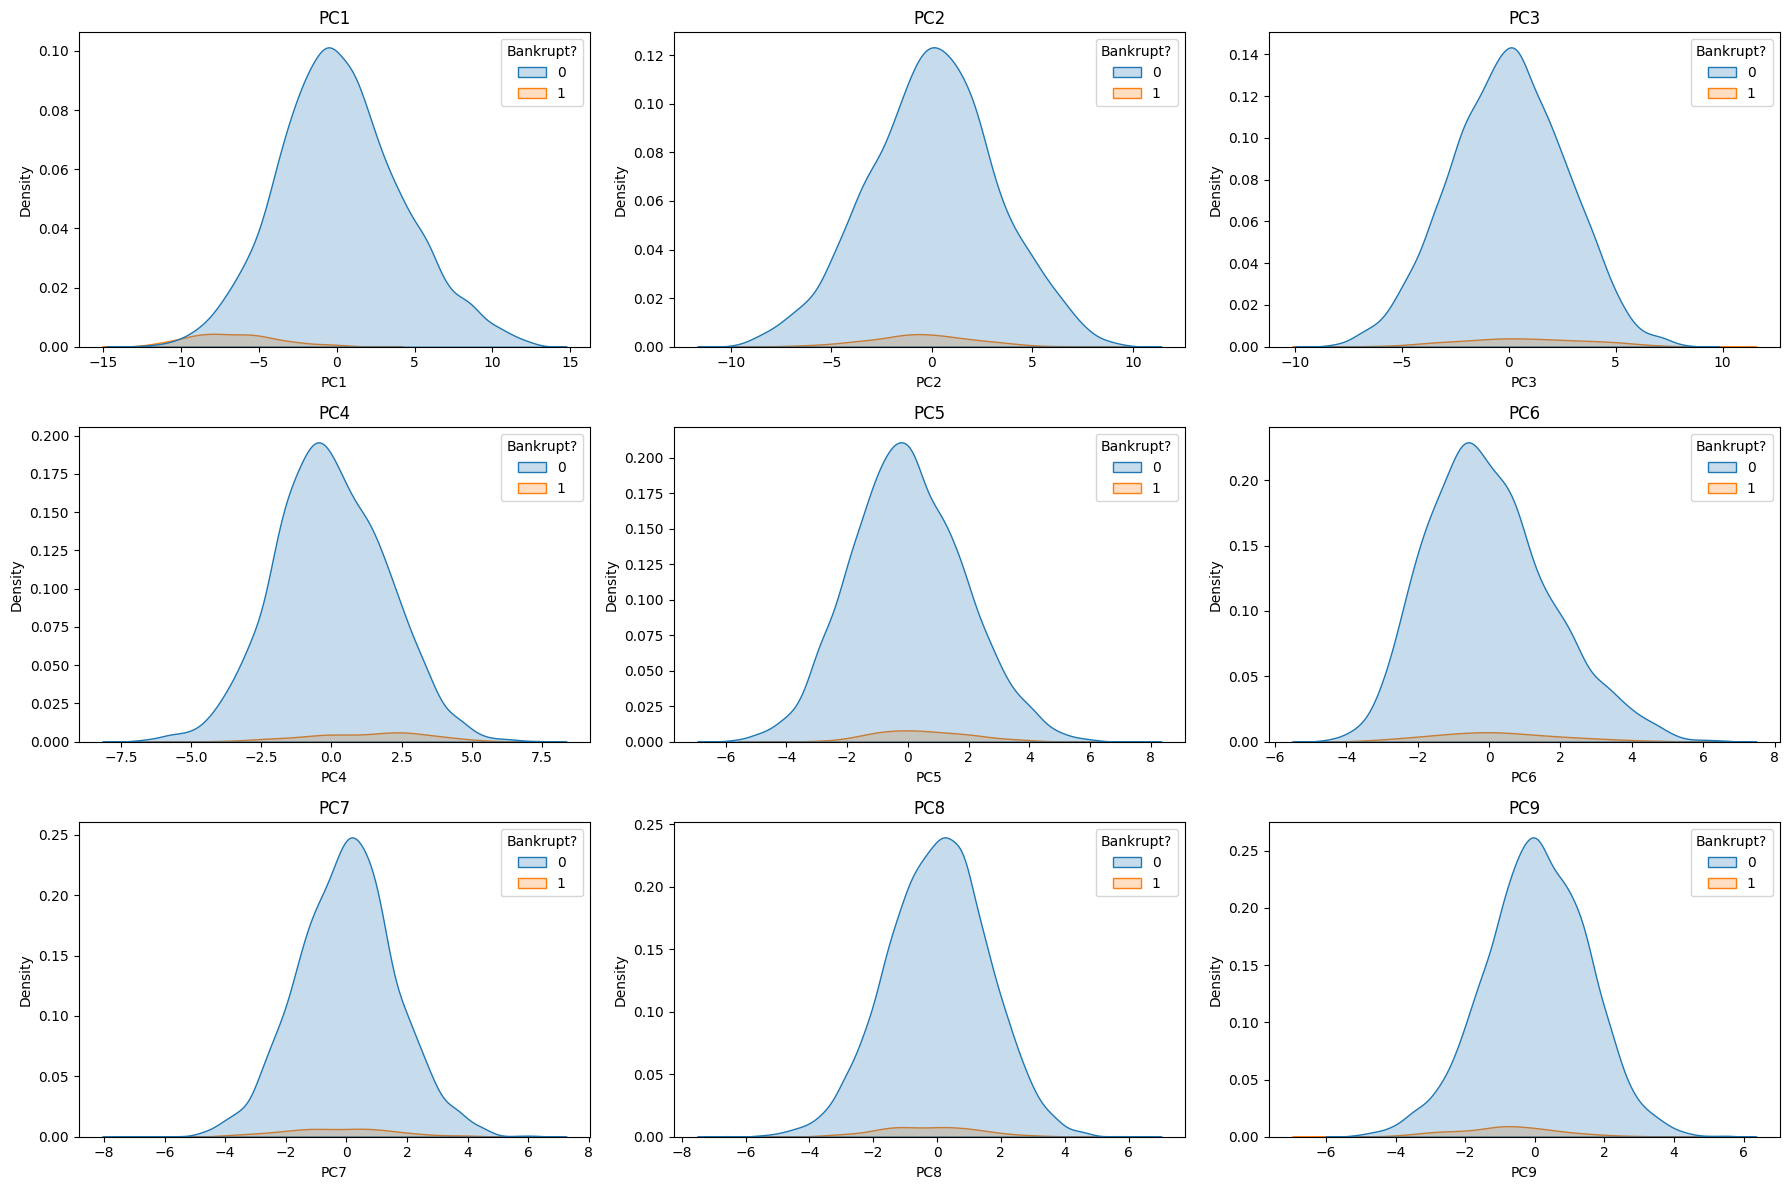

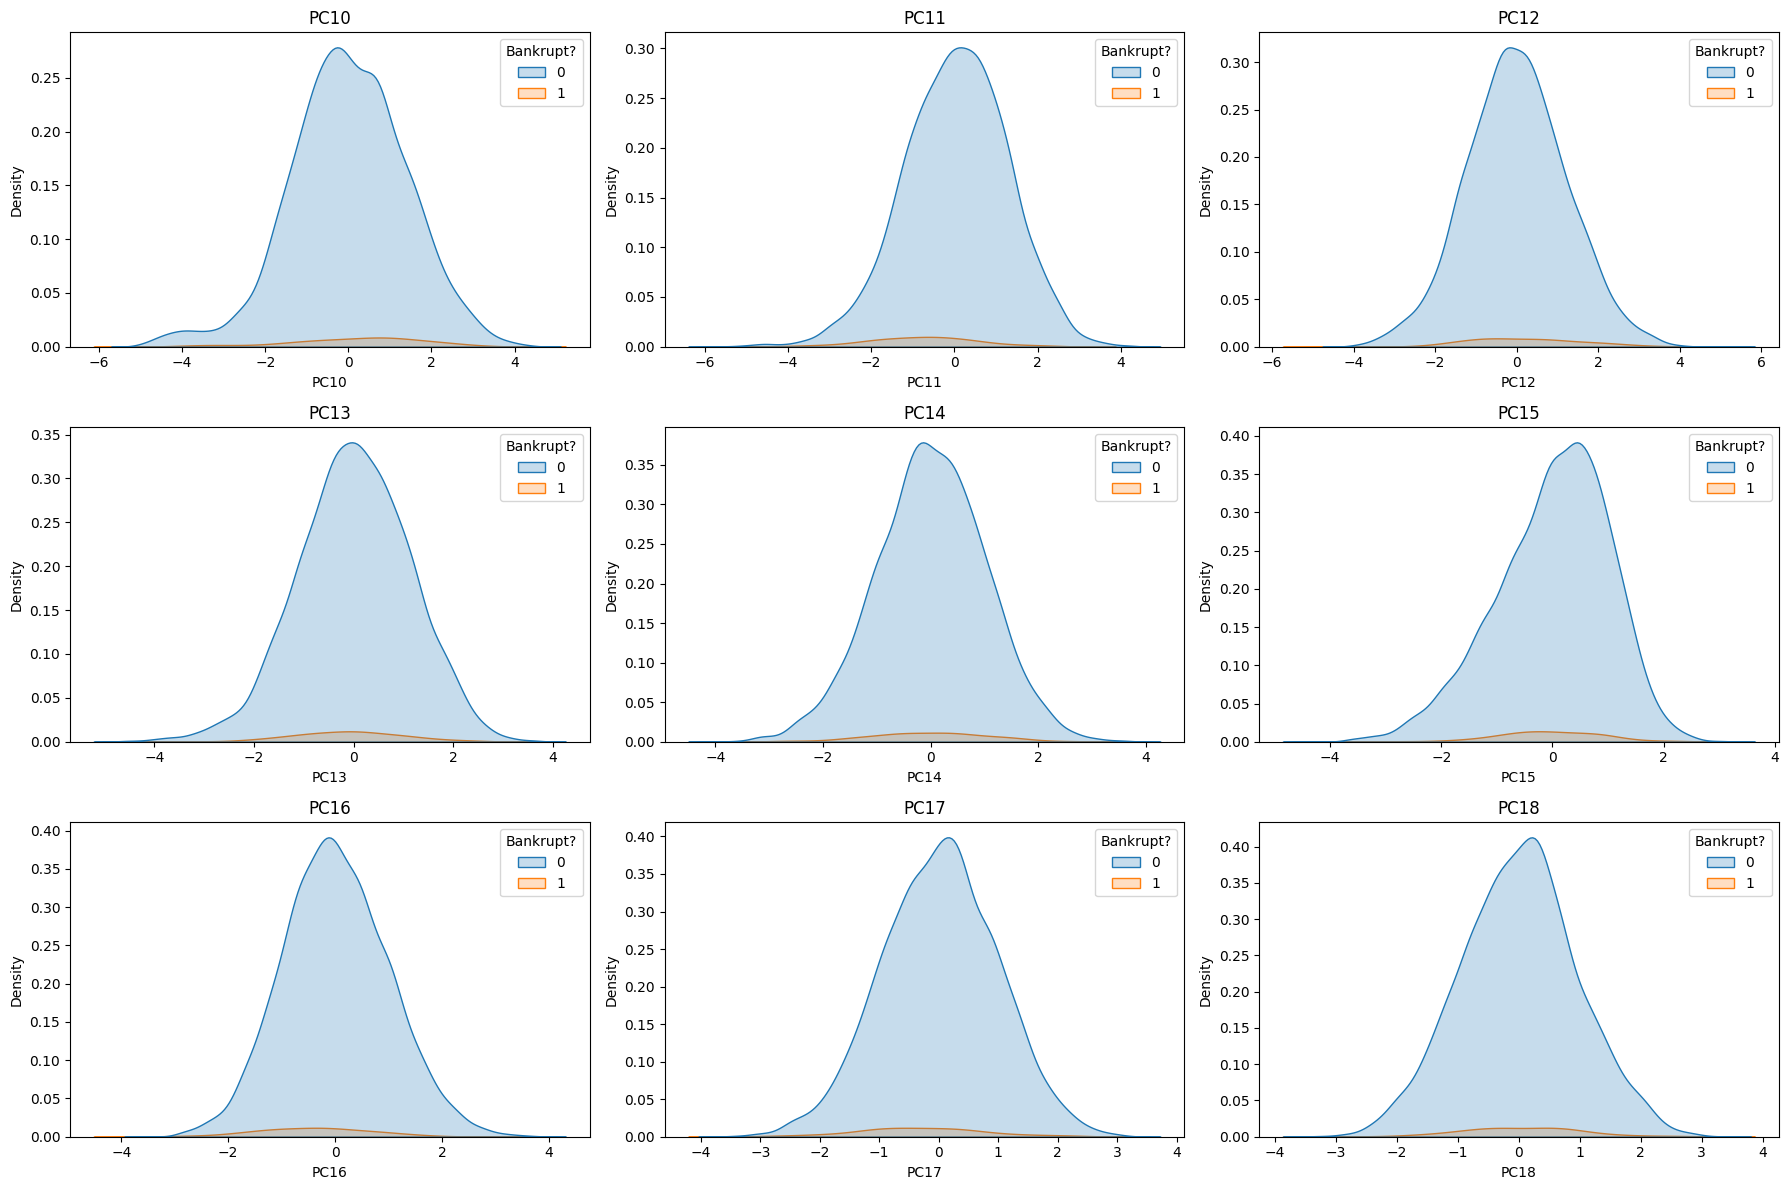

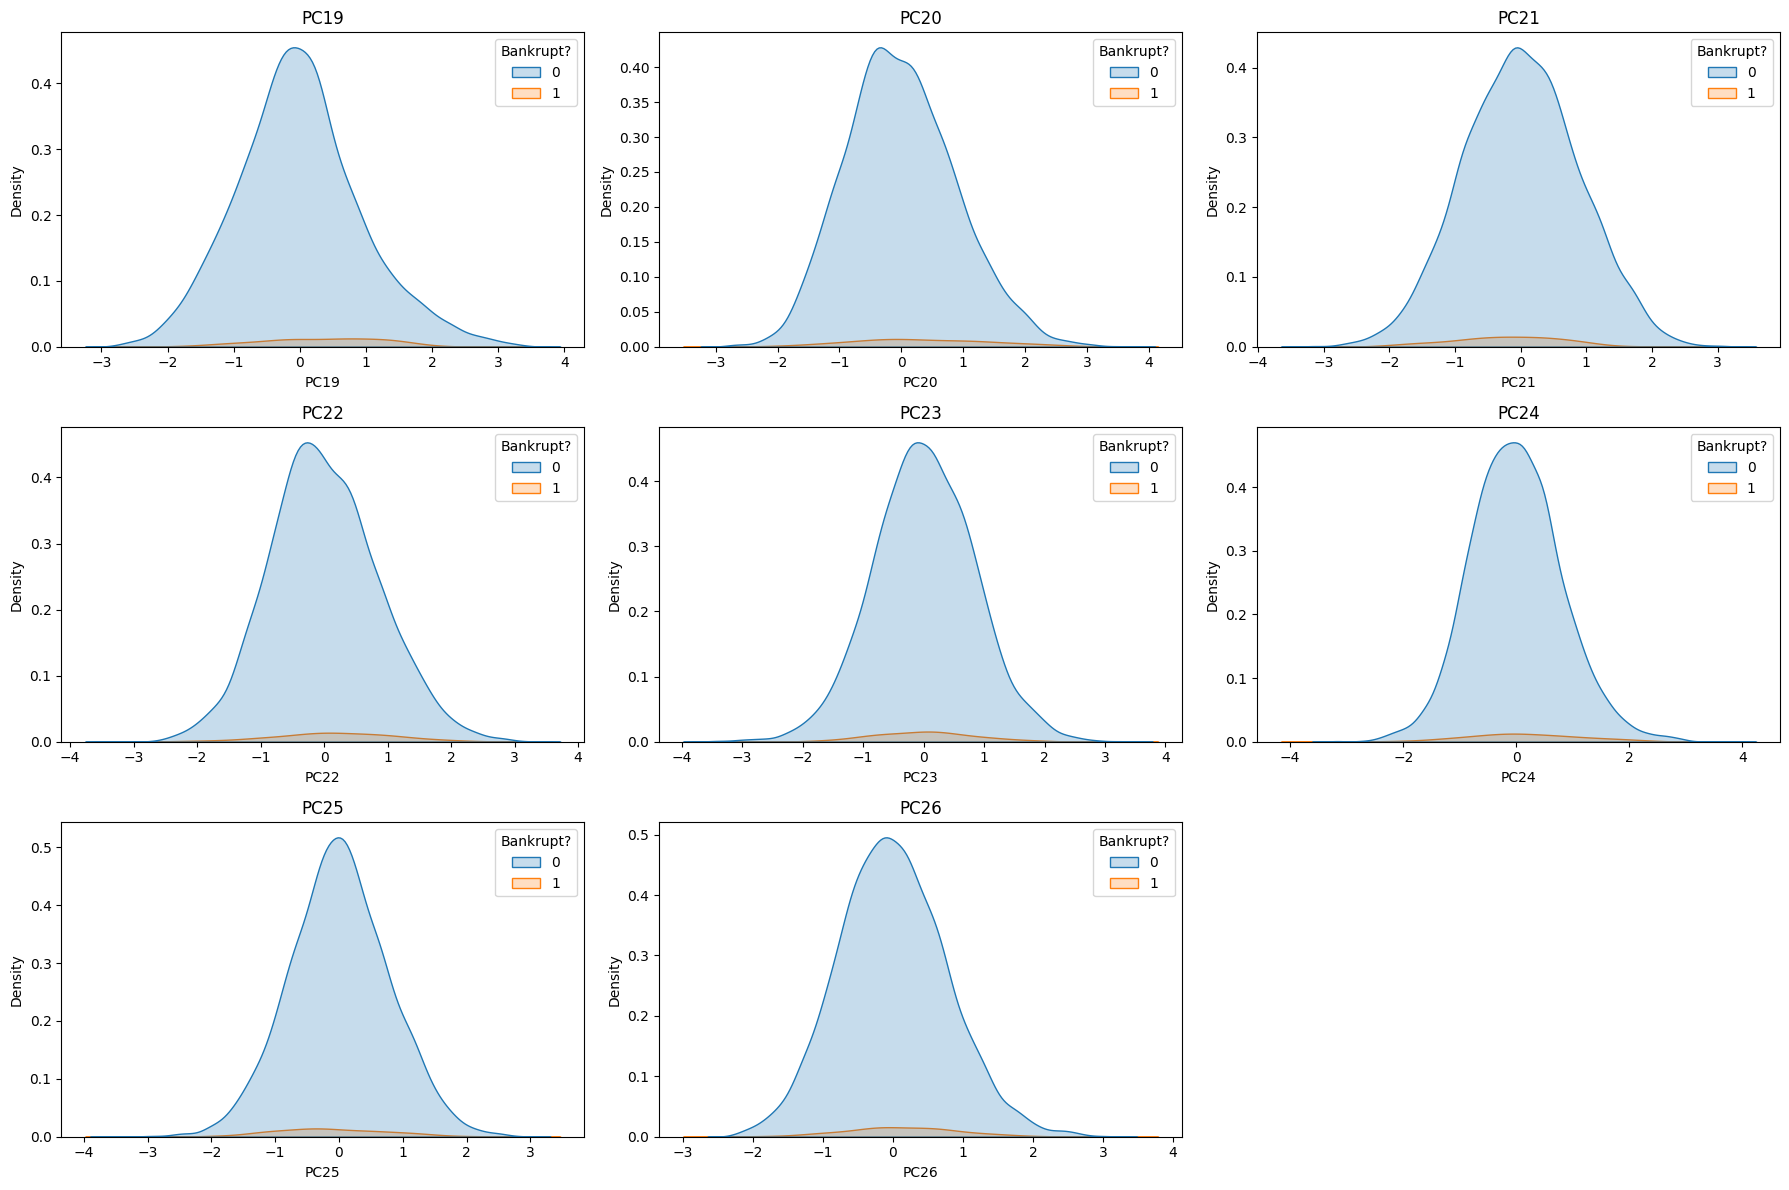

In [127]:
df_final = X_pca.copy()
df_final["Bankrupt?"] = y.values
final_features = list(X_pca.columns)

def plot_features(data, features, target='Bankrupt?', num_cols=3):
    for i in range(0, len(features), num_cols * 3):
        subset = features[i:i + num_cols * 3]
        rows = (len(subset) + num_cols - 1) // num_cols
        fig, axes = plt.subplots(rows, num_cols, figsize=(6 * num_cols, 4 * rows))
        axes = axes.flatten()
        for j, feature in enumerate(subset):
            sns.kdeplot(data=data, x=feature, hue=target, fill=True, ax=axes[j])
            axes[j].set_title(feature)
        for j in range(len(subset), len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        plt.show()

plot_features(df_final, final_features)

## Section 3.2 - Company Characterization 

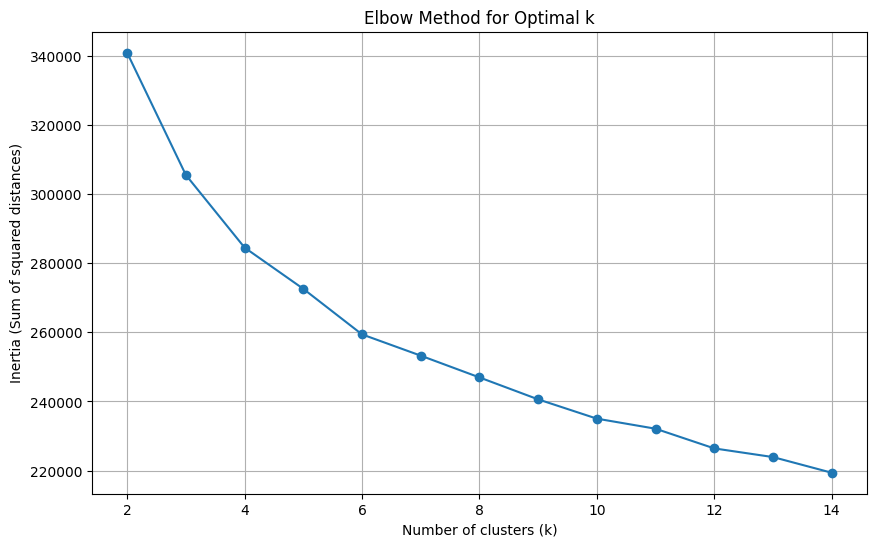

In [128]:
# Assume X_final is your PCA-reduced feature set (as a NumPy array or DataFrame)
inertia = []
K = range(2, 15)  # Try between 2 and 14 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of squared distances)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()



Elbow method, shows that the optimal k is 5

In [129]:
k = 5
RANDOM_STATE = 42
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
c_ids = kmeans.fit_predict(X_pca)
X_pca['cluster_id'] = c_ids+1

In [130]:
for i in range(k):
    print(f'Cluster {i+1}: {X_pca[X_pca["cluster_id"] == i+1].shape[0]} samples')

Cluster 1: 1150 samples
Cluster 2: 1548 samples
Cluster 3: 1002 samples
Cluster 4: 1135 samples
Cluster 5: 972 samples


In [131]:
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,cluster_id
0,-4.328723,-2.949938,-0.922311,1.347478,-1.875776,3.104547,-0.037355,-0.808933,1.108289,-0.216169,...,0.597473,-0.567413,-0.585520,1.535418,0.053807,0.107681,0.011554,1.276770,0.275025,4
1,1.094151,1.472453,0.132183,-0.300871,-0.504754,-1.832859,-0.031414,-1.170645,0.008114,-0.556370,...,-0.109543,-1.075769,-0.945268,-0.668545,-1.454529,-1.121609,0.843183,-0.421891,-0.419246,2
2,4.088633,1.259710,-1.776226,1.050030,1.501352,-0.340699,0.833061,-2.429603,-0.968284,0.329488,...,0.542483,0.710081,-0.577257,-0.530180,-0.899643,-0.333037,-1.430197,0.090152,-0.655980,2
3,-3.933860,6.750754,2.322990,-4.176331,2.404033,3.765933,0.485070,0.206727,-1.427313,-1.984952,...,0.970911,-1.761042,1.424276,1.402486,0.986018,1.197131,0.408706,0.192866,-0.402362,3
4,-0.695598,2.372324,3.048846,0.490309,-3.344630,0.242807,0.115051,0.733233,2.672528,2.512248,...,0.075081,-0.304360,-0.521027,-1.303879,0.050446,1.210307,0.004957,-0.065199,1.614544,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,-5.203183,4.031399,-1.581381,1.820330,-0.722545,2.028990,0.957132,0.630203,2.033828,2.132394,...,0.094430,0.174076,2.099330,0.006118,-0.791407,-1.386877,-2.299045,0.043732,-1.686468,1
5803,4.902789,-0.720811,-1.637984,1.788276,1.356479,0.370058,-0.787408,0.526895,-0.621148,-1.903530,...,-0.396504,0.458130,0.187679,0.516685,-0.450227,-0.364332,0.938161,1.827889,-0.292877,5
5804,-0.236553,3.246341,4.359812,1.112903,-2.900938,2.344548,0.729337,0.297779,1.444583,0.676542,...,-0.695289,0.165836,-0.303646,-0.785945,-0.318931,-0.123591,0.970680,0.812879,-0.446003,3
5805,4.654429,-0.126940,3.109156,3.148626,3.840758,2.273918,0.652784,-0.017399,-0.667480,1.745919,...,-0.854298,-1.251939,0.627141,0.380296,-0.856551,0.892200,1.461094,0.098640,1.889327,5


### Histogram of each feature by cluster 

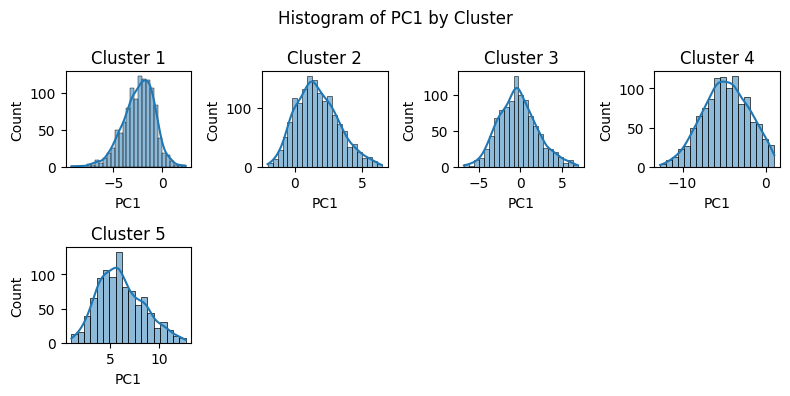

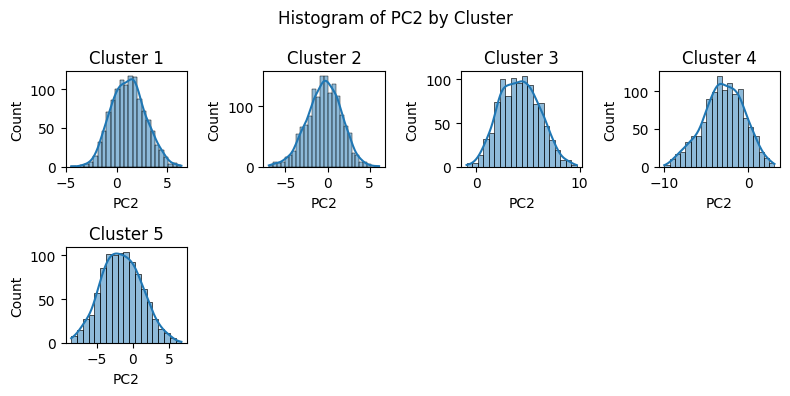

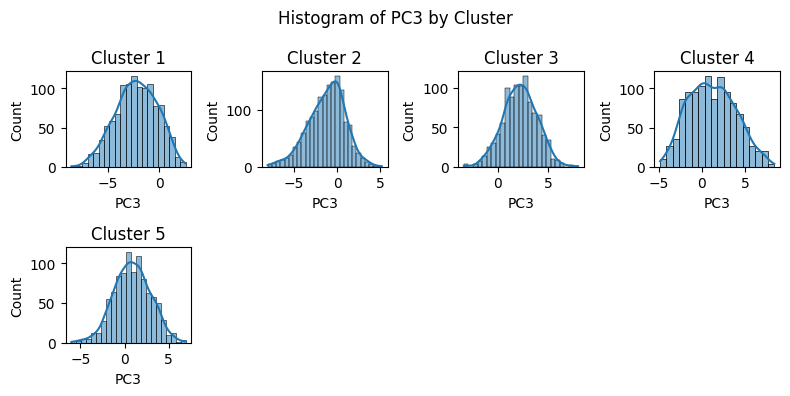

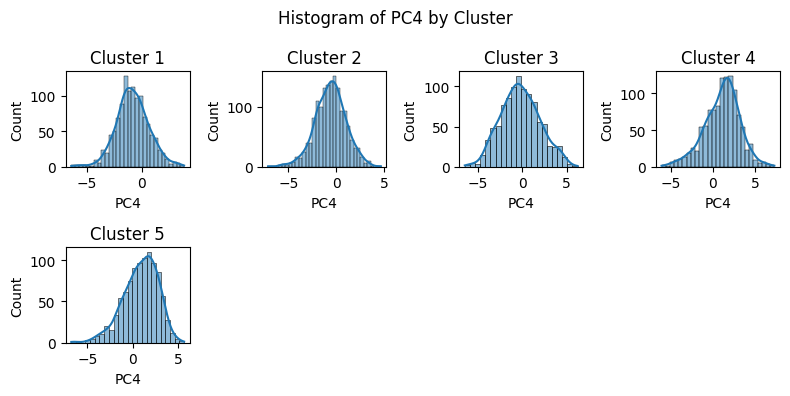

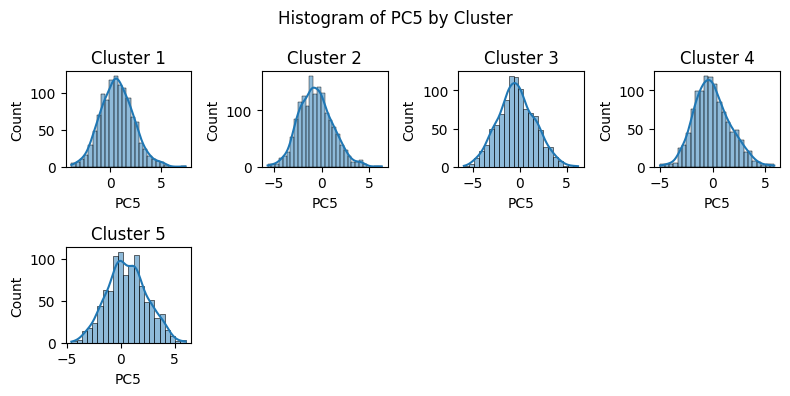

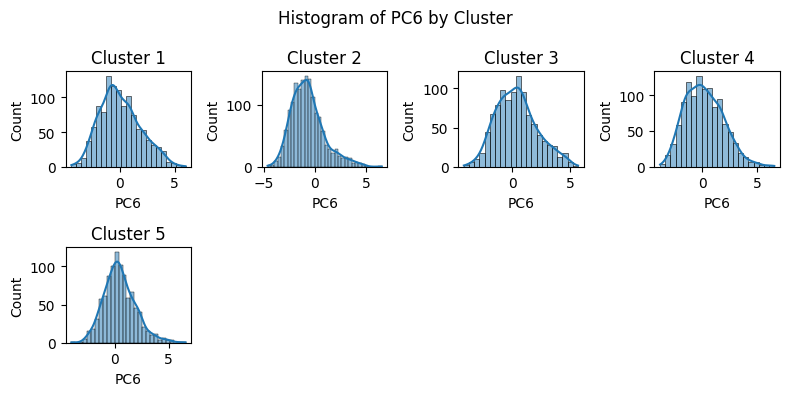

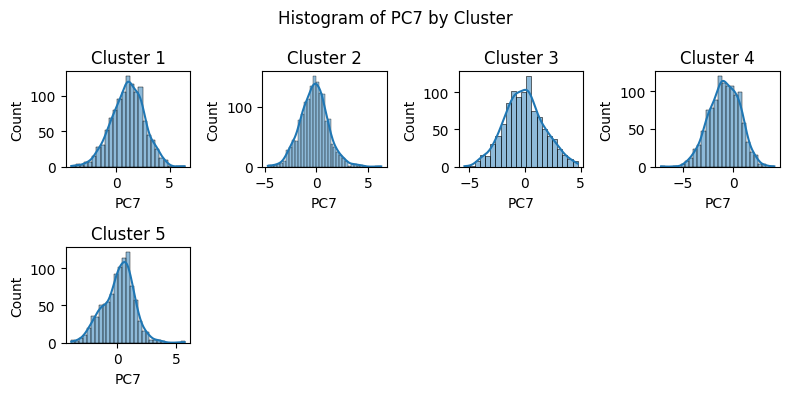

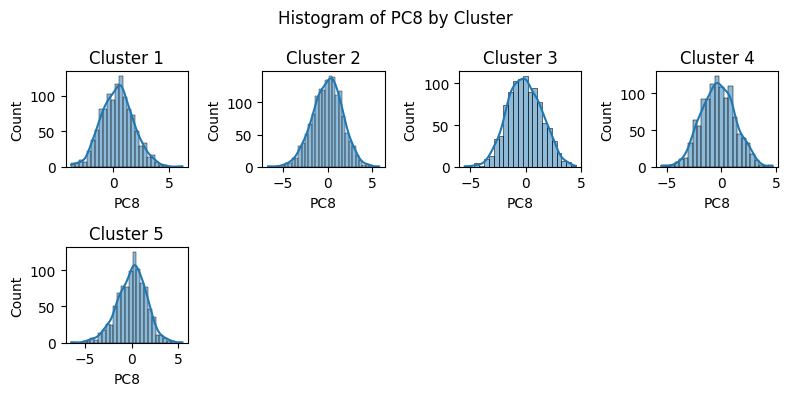

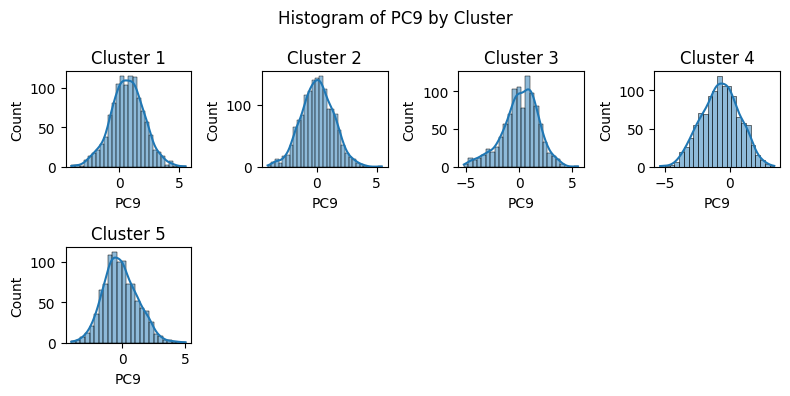

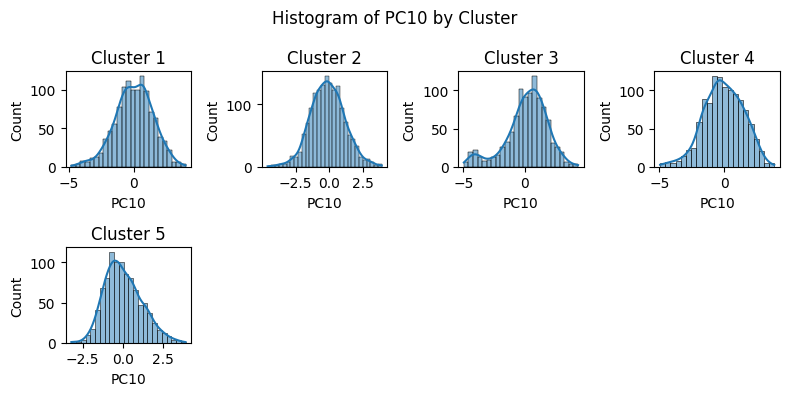

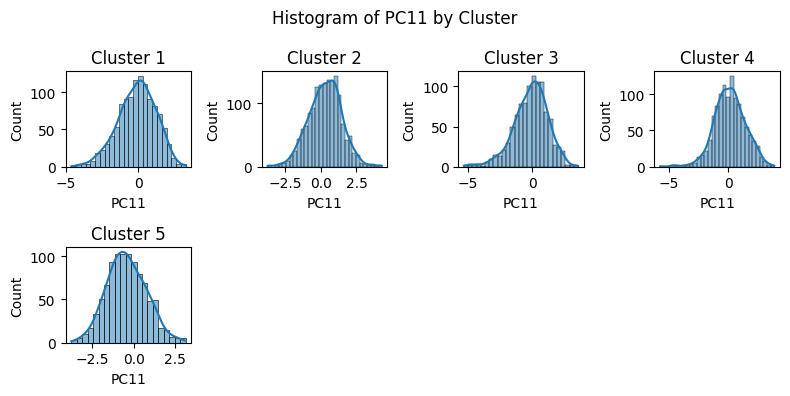

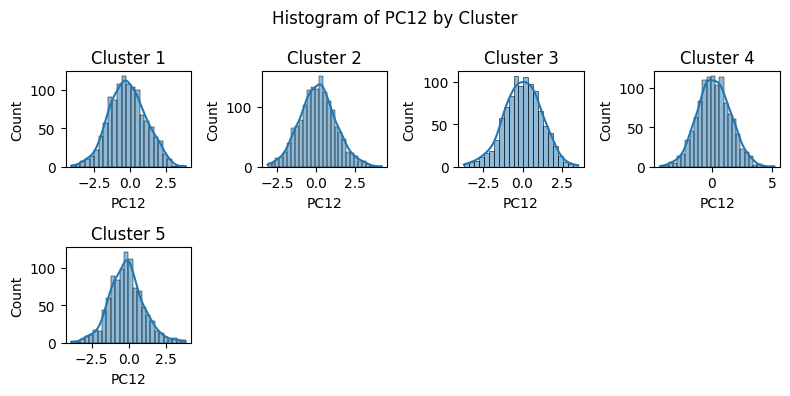

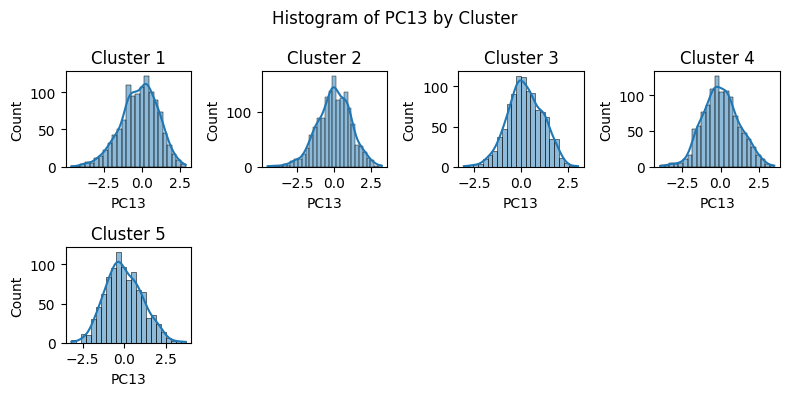

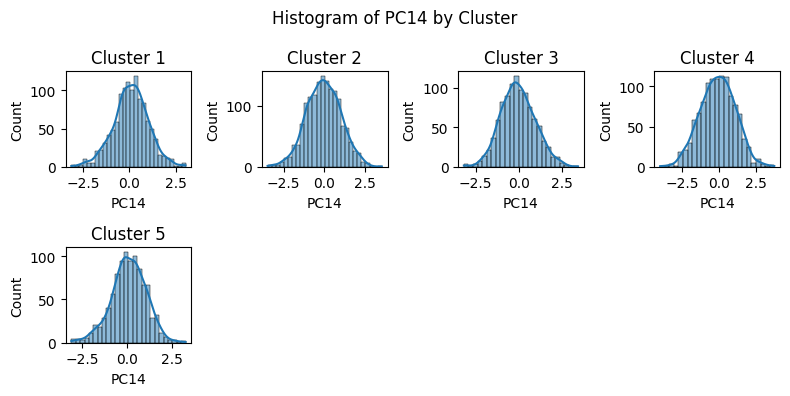

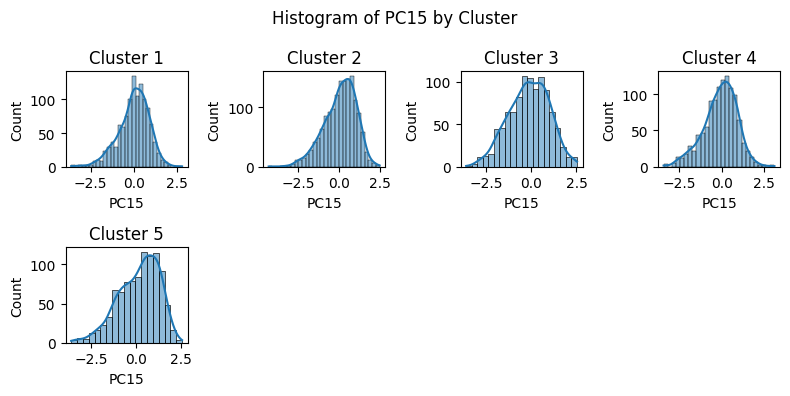

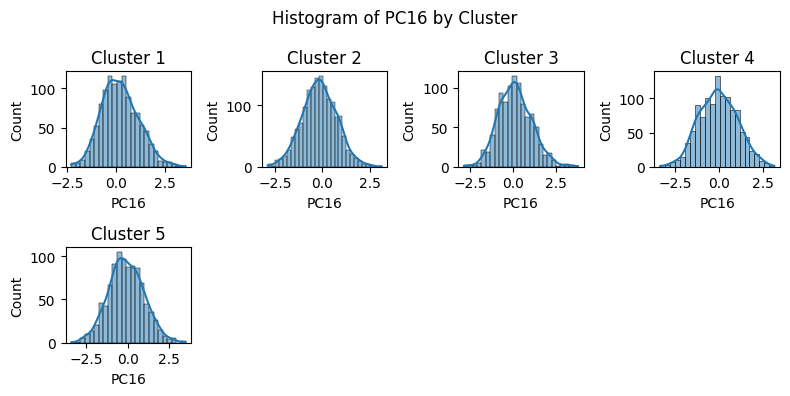

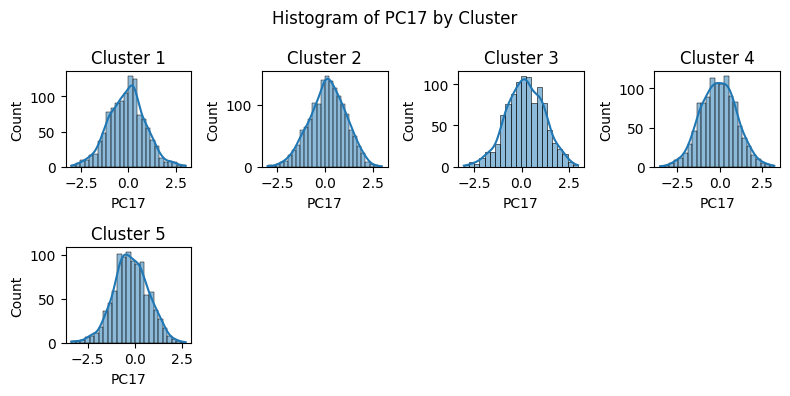

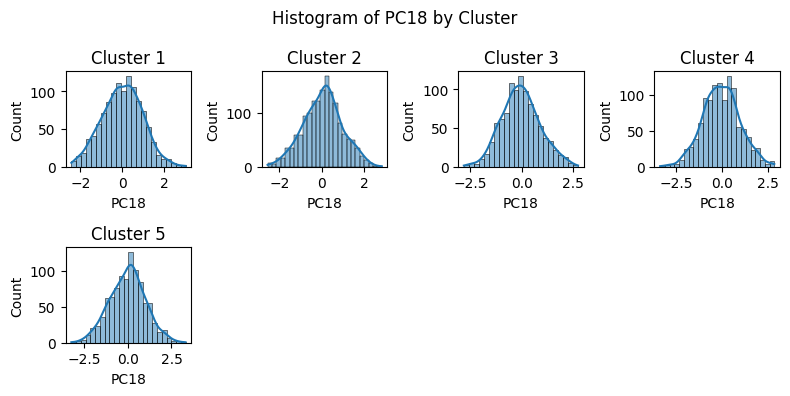

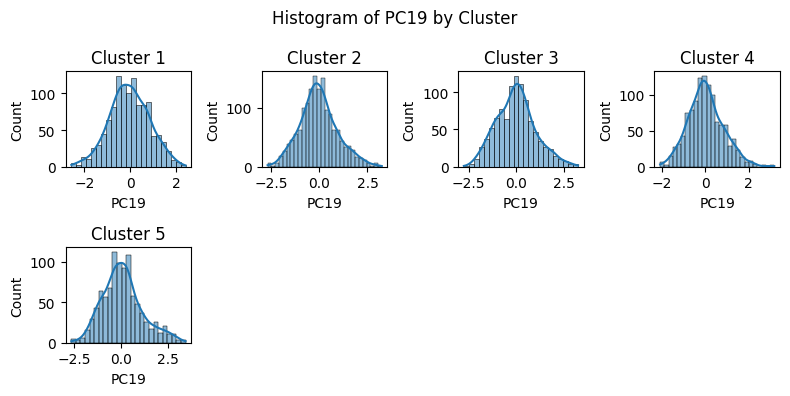

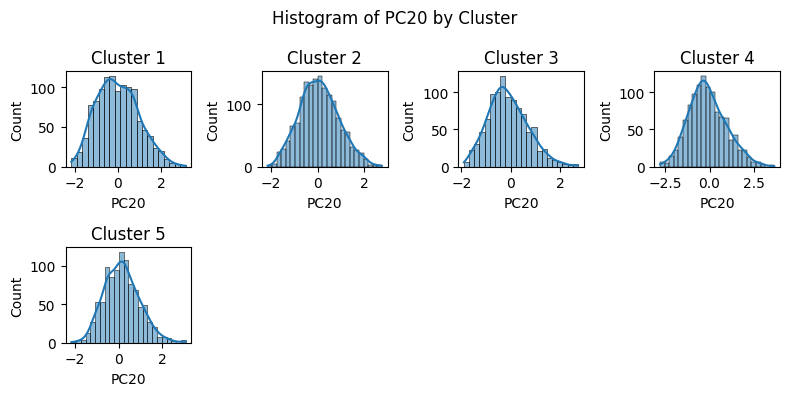

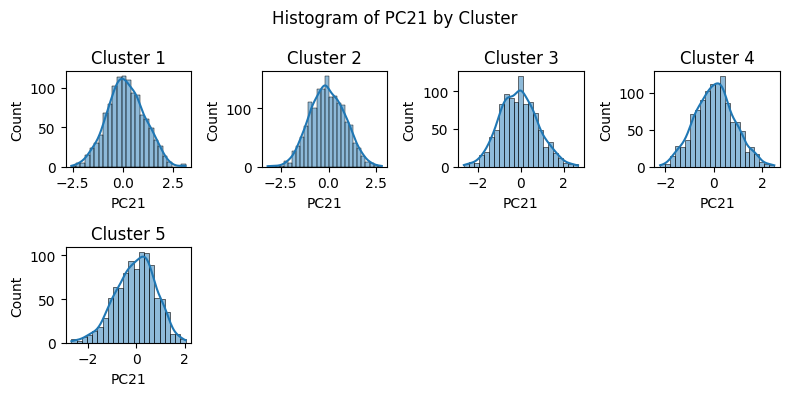

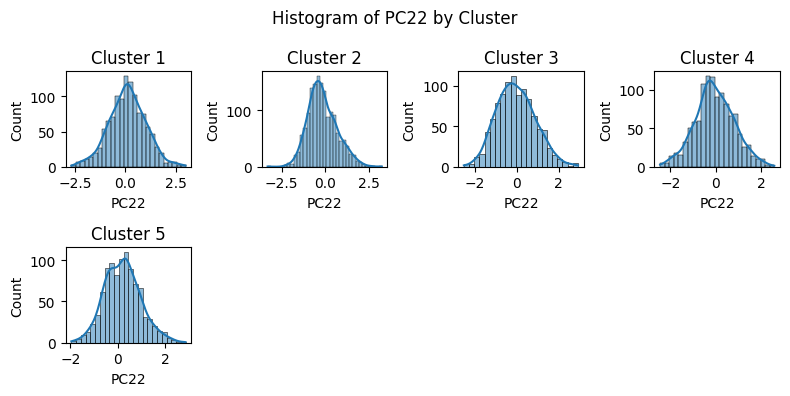

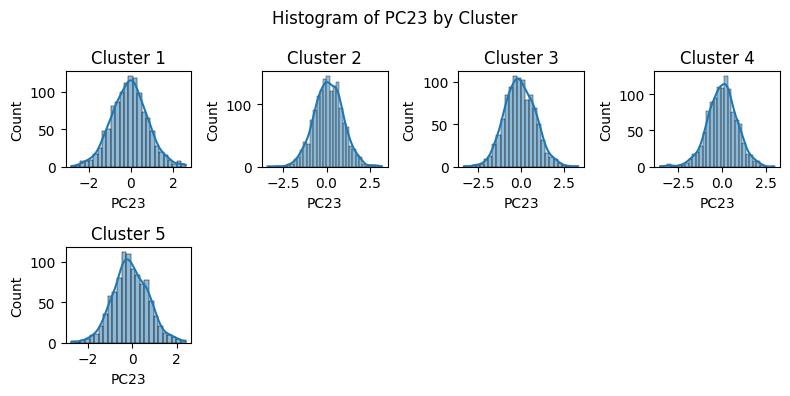

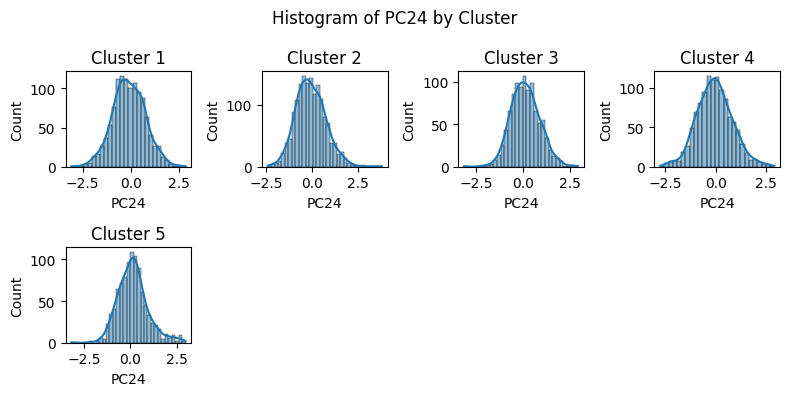

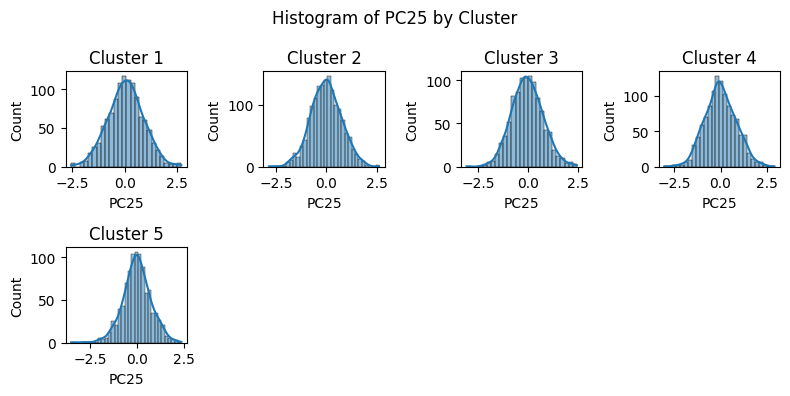

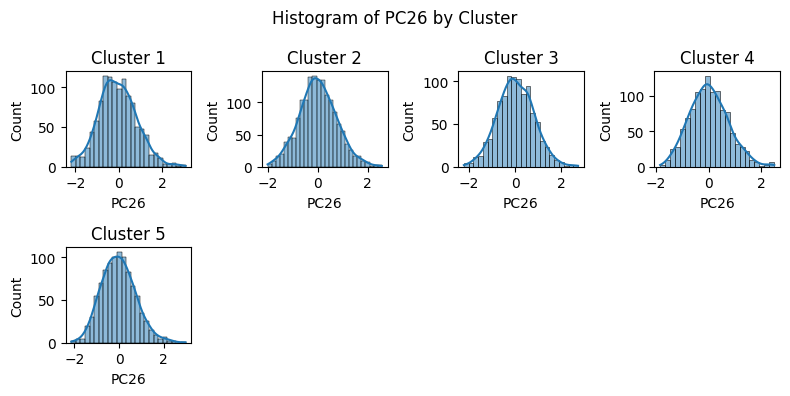

In [132]:
for column in X_pca.columns[:-1]:
    plt.figure(figsize=(8, 4))
    for i in range(k):
        plt.subplot(2, 4, i+1)
        sns.histplot(X_pca[X_pca['cluster_id'] == i+1][column], kde=True)
        plt.title(f'Cluster {i+1}')
        plt.xlabel(column)
    plt.suptitle(f'Histogram of {column} by Cluster')
    plt.tight_layout()
    plt.show()

In [146]:
df_final = X_pca.copy()
df_final["Bankrupt"] = y.values
# Cluster summary: count and bankruptcy rate
cluster_summary = df_final.groupby("cluster_id")["Bankrupt"].agg(["count", "sum"])
cluster_summary["Bankrupt_Rate"] = cluster_summary["sum"] / cluster_summary["count"]
cluster_summary

,count,sum,Bankrupt_Rate
cluster_id,,,
1,1150,41,0.035652
2,1548,3,0.001938
3,1002,11,0.010978
4,1135,143,0.125991
5,972,0,0.000000


## Section 3.3(Step 1) : Predicting the cluster_is

#### This section is about predicting cluster_id_pred.

In [155]:
cluster_ids = X_pca['cluster_id']
X_training = X_pca.drop('cluster_id', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_training, cluster_ids, test_size=0.2, random_state=RANDOM_STATE)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Validation set: {X_valid.shape[0]} samples')


Training set: 4645 samples
Validation set: 1162 samples


In [156]:
# Lets build different models and compare them
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print(f'{name} accuracy: {accuracy}')

Logistic Regression accuracy: 0.9905335628227194
Random Forest accuracy: 0.9182444061962134
SVM accuracy: 0.9724612736660929


The best model to predict the cluster IDs is Logistic Regression.

In [157]:
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model.fit(X_training, cluster_ids)
# Find accuracy
cluster_id_pred = model.predict(X_training)
accuracy = accuracy_score(cluster_ids, cluster_id_pred)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 1.00%


In [158]:
df_final["cluster_id_pred"] = cluster_id_pred
df_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,Bankrupt,cluster_id_pred
0,-4.328723,-2.949938,-0.922311,1.347478,-1.875776,3.104547,-0.037355,-0.808933,1.108289,-0.216169,...,-0.567413,-0.585520,1.535418,0.053807,0.107681,0.011554,1.276770,0.275025,0,4
1,1.094151,1.472453,0.132183,-0.300871,-0.504754,-1.832859,-0.031414,-1.170645,0.008114,-0.556370,...,-1.075769,-0.945268,-0.668545,-1.454529,-1.121609,0.843183,-0.421891,-0.419246,0,2
2,4.088633,1.259710,-1.776226,1.050030,1.501352,-0.340699,0.833061,-2.429603,-0.968284,0.329488,...,0.710081,-0.577257,-0.530180,-0.899643,-0.333037,-1.430197,0.090152,-0.655980,0,2
3,-3.933860,6.750754,2.322990,-4.176331,2.404033,3.765933,0.485070,0.206727,-1.427313,-1.984952,...,-1.761042,1.424276,1.402486,0.986018,1.197131,0.408706,0.192866,-0.402362,0,3
4,-0.695598,2.372324,3.048846,0.490309,-3.344630,0.242807,0.115051,0.733233,2.672528,2.512248,...,-0.304360,-0.521027,-1.303879,0.050446,1.210307,0.004957,-0.065199,1.614544,0,3


### Save the processed data to a new csv file including the `cluster_id_pred`

In [159]:
df_final.to_csv('train_data_Processed.csv', index=False)
print("Data saved to train_data_Processed.csv")

Data saved to train_data_Processed.csv


### Saved the Trained Subgroup Classifier and the selected columns after the correlation filtering

In [160]:
# Save selected columns after correlation filtering  
joblib.dump(selected_columns.tolist(), "selected_columns.pkl")

joblib.dump(model, "subgroup_classifier.pkl")
joblib.dump(X_training.columns.tolist(), "subgroup_classifier_features.pkl")

['subgroup_classifier_features.pkl']